## Regression model with DL 
The newswire problem as well as moview review problems seen earlier were classification problems. 
Now we try to solve a regression problem where we try and predict a continuous value rather than a label to categorize the record. 

**Boston House Prices Dataset** 
Here we try and predict house prices in a Boston suburb based on the data of house prices in Boston in mid 1970's 

In [1]:
import tensorflow as tf 
from tensorflow import keras 

In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [6]:
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train targets: {train_targets.shape}")
print(f"Shape of test data: {test_data.shape}")
print(f"Shape of test targets: {test_targets.shape}")

# you have 404 training samples with 13 features each and 102 test samples with 13 features each
print(f"train Data set 0 {train_data[0]}")
print(f"train target set 0 {train_targets[0]}")

Shape of train data: (404, 13)
Shape of train targets: (404,)
Shape of test data: (102, 13)
Shape of test targets: (102,)
train Data set 0 [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
train target set 0 15.2


## 1 Prepare the data 
The data that we have in the data set (each feature) has a different range of values and they all vary from one another. 
WHen looking to train a DL model we need to keep in mind the ranges that the features we are using to train model. If each feature has a wide range different from each other the model will have a difficult time learning. 

Solution to this problem is to normalize the feature wise data. This means: 
1. for each feature in the input data we subtract the mean of the feature and 
2. for each feature divide the difference above by the standard deviation of the feature. 

This nomalizes the data and makes learning easier for the DL model. 

In [9]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

print(f"train Data set 0 {train_data[0]}")
print(f"train Data set 1 {train_data[1]}")
# here we see the features normalized and in the same range (ballpark)

train Data set 0 [-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
train Data set 1 [-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
 -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
 -1.32920239]


## 2. Build the DL model 
Since the data set is small and we have few values for training and predicting we keep the layers small and have 2 Dense layer with 16 input units. Final layer is a 1 node layer as we need to get one value. 

In [11]:
def build_model():
    # Important bit here is that that we do not have any activation function as the last layer as we need a continuous prediction
    h_model = keras.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    # compile the model with loss of mean squared error as we need a continuous prediction. 
    # the metrics is mean absolute error
    h_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return h_model



## 3. Prepare the validation data set using K fold 
Since the data set we have is small and training set is even smaller if we further divide the training set into train and validation set we may not get a true validation based on high variance. Therefore the approach used in this case is the k fold validation. 

We split the data in k partitions (k = 4 or 5) and then training the model with k-1 paritions of the data and validate with remaining split. This way we get k-1 scores of validation. We take these k-1 validation scores and average them out to get a true store. 

In [12]:
import numpy as np
# 1. First we do k fold validation to get MSE for each fold.
k = 4 
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold # {i}")
    # split the data into val_data set. 
    val_data = train_data[i * num_val_samples // k: (i+1) * num_val_samples // k]
    val_targets = train_targets[i * num_val_samples // k: (i+1) * num_val_samples // k]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    h_model = build_model()
    h_model.fit(partial_train_data, 
                partial_train_targets, 
                epochs=num_epochs, 
                batch_size=16, 
                verbose=0)
    val_mse, val_mae = h_model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [13]:
print(f"all scores: {all_scores}")

all scores: [2.3074288368225098, 1.2915846109390259, 1.1004729270935059, 1.454209566116333]


In [14]:
overall_mse = np.mean(all_scores)

print(f"overall mse: {overall_mse}")

overall mse: 1.5384239852428436


In [15]:
# Now we save values of mae for each epoch.
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                   
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()                                                  
    history = model.fit(partial_train_data, partial_train_targets,         
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [16]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

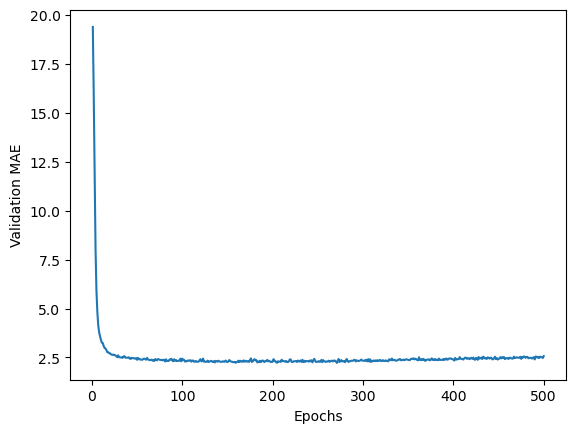

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

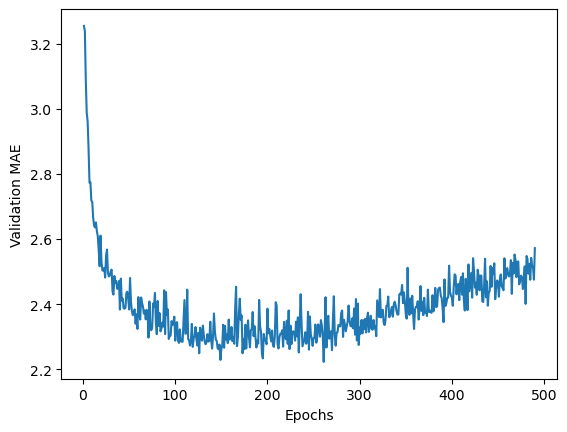

In [18]:
# we truncate the first 10 data points as they are on a different scale
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [19]:
# we can see that after 120 epochs we get a increase in MAE so we can train the model for 120 epochs
model = build_model()
model.fit(train_data, train_targets, 
          epochs=120, 
          batch_size=16, 
          verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 836us/step - loss: 16.4831 - mae: 2.5890


In [21]:
print(f"Test MSE score: {test_mse_score}")
print(f"Test MAE score: {test_mae_score}")

Test MSE score: 16.48314666748047
Test MAE score: 2.588972806930542


## 4. Predicting using test data. 

In [23]:
pred = model.predict(test_data)
print(f"Prediction: {pred[0]}")


4/4 [==============================] - 0s 614us/step
Prediction: [8.197303]


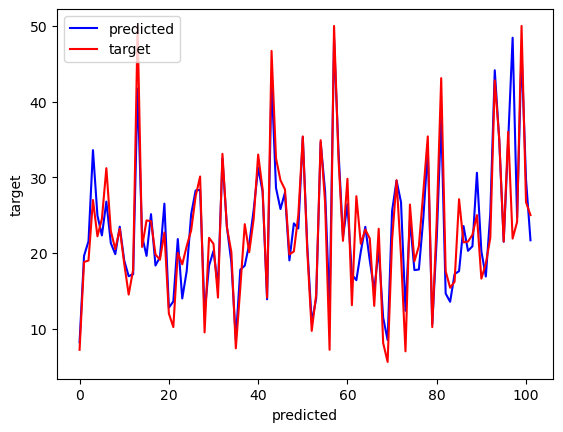

In [25]:
# here we see the plots and the difference between the predicted and the target values
plt.clf() 
plt.plot(pred,'b', label="predicted")
plt.plot(test_targets,'r', label="target")
plt.xlabel("predicted")
plt.ylabel("target")
plt.legend()
plt.show()